## Demonstration of the LON algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from tqdm.auto import tqdm
from functions import *
import networkx as nx
import igraph as ig
import time
plt.ion()
#  colors 
dark_red = "#de2d26"
light_red = "#fee0d2"
light_blue = "#a6bddb"
# parameters
problem = RastriginMin5d
beta = 0.4749 # Rastrigin
multiplier = 1
tolerance = 10**(-5) # tolerance for x equivalency
budget = 100
# random seeding
seed = 12345
np.random.seed(seed)

In [2]:
def process_inds(optima, values, tolerance=10**(-4)):
    inds = np.ones(len(optima), dtype=int)*-1
    count = 0
    pbar = tqdm(total = len(inds))
    for i in range(len(inds)):
        pbar.set_description("Processing index: %s " % str(i))
        if inds[i]< 0:
            eq_inds = np.where(np.all(np.abs(optima[i] - optima) <= tolerance, axis=1)==True)[0]
            inds[eq_inds] = count
            count += 1
        pbar.update(1)
    pbar.close()
    return inds
    
def plot_graph(opts, vals, lengs, tolerance=10**(-5)):
    for i in range(1, len(lengs)):
        lengs[i] = lengs[i-1]+lengs[i] 
    inds = process_inds(opts,vals, tolerance=tolerance)
    unique, counts = np.unique(inds, return_counts=True)
    G = nx.DiGraph()
    G.add_nodes_from(unique)
    count = 0
    for i in range(1, len(opts)):
        if i not in lengs:
            G.add_edge(inds[i-1], inds[i])
    best_ind = np.argmin(vals)
    best_node_label = inds[best_ind]
    best_subgraph = nx.bfs_tree(G, best_node_label, reverse=True)
    pos = nx.spring_layout(G)
    node_size = [np.log(counts[i]*1000)*10+50 for i in range(len(unique))]
    node_color = []
    for i in range(len(unique)):
        if unique[i] in best_subgraph:
            if unique[i] == best_node_label:
                node_color.append(dark_red)
            else:
                node_color.append(light_red)
        else:
            node_color.append(light_blue)
    nx.draw(G, pos, node_color=node_color, node_size=node_size, alpha=0.5)
    return G

In [3]:
# basin hopping -- from LON paper
def basin_hopping(problem, step_size, 
                    iter_limit = 1000, opt_config={}):
    function = problem.fitness
    lower_bounds, upper_bounds = problem.get_bounds()
    optima = []
    values = []
    # local search parameters -- from LON paper
    method = opt_config.get("method", "L-BFGS-B")
    tol = opt_config.get("tol", 10**-7)
    maxiter = opt_config.get("maxiter", 15000)
    # initial solution
    x_init = np.random.uniform(low=lower_bounds, high=upper_bounds)
    res = optimize.minimize(function, x0=x_init, method=method, tol=tol,
                            options={"maxiter":maxiter})
    if res["success"]:
        x_opt = res["x"]
        optima.append(x_opt)
        values.append(function(x_opt))
    else:
        raise Exception("Optimiser failed!")
    counter = 0
    while True:
        x_new = x_opt + np.random.uniform(low=-step_size, high=step_size)
        x_new = np.clip(x_new, lower_bounds, upper_bounds)
        res = optimize.minimize(function, x0=x_new, method=method, tol=tol,
                                    options={"maxiter":maxiter})
        if res["success"]:
            x_nopt = res["x"]
        else:
            raise Exception("Optimiser failed!")
        if function(x_nopt) <= function(x_opt):
            x_opt = x_nopt
            optima.append(x_opt)
            values.append(function(x_opt))
            counter = 0
        else:
            counter += 1
        if counter >= iter_limit:
            break
    return np.array(optima), np.array(values)

def run_multiple_hoppers(problem, beta, multiplier, budget=100, iter_limit=1000, opt_config={}):
    opts, vals, lengs = [], [], []
    count = 0
    pbar = tqdm(total = budget)
    while True:
        try:
            # print("Run no: ", count + 1)
            pbar.set_description("Run number: %s " % str(count+1))
            optima, values = basin_hopping(problem, beta*multiplier, iter_limit, **opt_config)
            opts.append(optima)
            vals.append(values)
            lengs.append(len(optima))
            count += 1
            pbar.update(1)
        except Exception as e:
            print(e)
        if count >= budget:
            break
    pbar.close()
    opts = np.concatenate(opts)
    vals = np.concatenate(vals)
    lengs = np.array(lengs)
    return opts, vals, lengs


def plot_LON(problem, beta, multiplier, tolerance=10**(-5), budget=100, iter_limit=1000, opt_config={}): 
    opts, vals, lengs = run_multiple_hoppers(problem, beta, multiplier, budget=budget)
    # optimum
    best_ind = np.argmin(vals)
    print("Optimal solution: ", opts[best_ind])
    print("Optimal value: ", vals[best_ind])
    # plot LON
    G = plot_graph(opts, vals, lengs, tolerance=tolerance)
    return G, opts, vals, lengs
    

Processing index: 291 :  37%|███▋      | 291/794 [00:00<00:00, 2021.74it/s]

Optimal solution:  [-4.58072862e+08  1.17672915e+09 -1.86187914e+08 -4.58072890e+08
 -4.58072903e+08]
Optimal value:  -2.0488497238054815e+18


Processing index: 793 : 100%|██████████| 794/794 [00:00<00:00, 1458.25it/s]


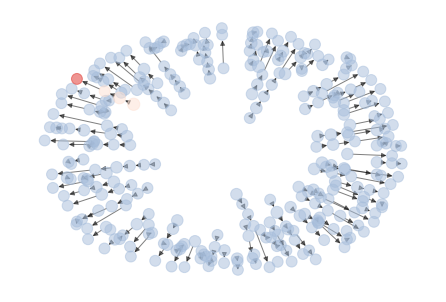

In [4]:
G, opt, vals, lengs = plot_LON(problem, beta, multiplier, budget=budget, tolerance=tolerance)